In [1]:
import pandas as pd
import numpy as np
import pickle
import torch
import time
import glob
import yaml
import sys
import os
import re

from holodecml.vae.tqdm import tqdm
from multiprocessing import Pool

import matplotlib.pyplot as plt
from typing import List

from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split as _train_test_split
from sklearn.pipeline import Pipeline

In [2]:
class LoadPandas:
    
    def __init__(self, path, summary_file, input_vars, output_vars):
        self.path = path
        self.summary_file = summary_file
        
        self.input_vars = input_vars
        self.output_vars = output_vars
        
    def add_diurnal_signal(self, x_data):
        """
        Apply Function to static temperature to add +- 4 [K] diurnal signal (dependent of time [s] of timeseries).
        Args:
            x_data: Pre-scaled/normalized input data (Pandas DF).

        Returns: Same df with function applied to temperature feature.
        """
        x_data['temperature (K)'] = x_data['temperature (K)'] + 4.0 * np.sin(
            (x_data['Time [s]'] * 7.2722e-5 + (np.pi / 2.0 - 7.2722e-5 * 64800.0)))

        return x_data
    
    def read(self, file_path):
        df = pd.read_csv(file_path)
        df.columns = [x.strip() for x in df.columns]

        ### Load the summary file
        exp_num = int(re.findall("_Exp(\d+)*", file_path)[0])
        summary_file = self.summary_file[(
            self.summary_file['id'] == f"Exp{exp_num}"
        )].copy()

        for variable in summary_file.columns:
            df[variable] = summary_file[variable][exp_num]

        df = self.add_diurnal_signal(df)

        input_subset = df[self.input_vars].iloc[:-1,:].copy()
        output_subset = df[self.output_vars].iloc[1:,:].copy()

        if "index" in input_subset.columns:
            input_subset = input_subset.drop(columns = ["index"])
        if "index" in output_subset.columns:
            output_subset = output_subset.drop(columns = ["index"])
            
        return input_subset, output_subset
        
    def load(self):
        
        file_list = glob.glob(os.path.join(self.path, 'ML2019_*'))
        file_list = sorted(file_list, key = lambda x: int(x.split("Exp")[1].strip(".csv")))
        self.summary_file = pd.read_csv(
            os.path.join(self.path, self.summary_file), skiprows = 3
        )
        self.summary_file.columns = [x.strip() for x in self.summary_file.columns]
        
        data_in, data_out = [], []
        with Pool(8) as p:
            for (input_subset, output_subset) in tqdm(p.imap(self.read, file_list), total = len(file_list)):
                data_in.append(input_subset)
                data_out.append(output_subset)
        data_in = pd.concat(data_in).reset_index(drop = True)
        data_out = pd.concat(data_out).reset_index(drop = True)
        
        #idx = np.random.permutation(data_in.index)
        #data_in = data_in.reindex(idx)
        #data_out = data_out.reindex(idx)
        
        self.data_in = data_in
        self.data_out = data_out
        
        return data_in, data_out

In [6]:
data_path = "/glade/p/cisl/aiml/gecko/ML2019_dodecane_postproc"
summary_file = "C02000_Exp_List_ML2019_dodecane_v1_LatinHyperCube.csv"

input_vars = [
    'Time [s]',
    'Precursor [ug/m3]',
    'Gas [ug/m3] Bin01: lg(C*) = -6.5',
    'Gas [ug/m3] Bin02: lg(C*) = -5.5',
    'Gas [ug/m3] Bin03: lg(C*) = -4.5',
    'Gas [ug/m3] Bin04: lg(C*) = -3.5',
    'Gas [ug/m3] Bin05: lg(C*) = -2.5',
    'Gas [ug/m3] Bin06: lg(C*) = -1.5',
    'Gas [ug/m3] Bin07: lg(C*) = -0.5',
    'Gas [ug/m3] Bin08: lg(C*) =  0.5',
    'Gas [ug/m3] Bin09: lg(C*) =  1.5',
    'Gas [ug/m3] Bin10: lg(C*) =  2.5',
    'Gas [ug/m3] Bin11: lg(C*) =  3.5',
    'Gas [ug/m3] Bin12: lg(C*) =  4.5',
    'Gas [ug/m3] Bin13: lg(C*) =  5.5',
    'Gas [ug/m3] Bin14: lg(C*) =  6.5',
    'Aerosol [ug_m3] Bin01: lg(C*) = -6.5',
    'Aerosol [ug_m3] Bin02: lg(C*) = -5.5',
    'Aerosol [ug_m3] Bin03: lg(C*) = -4.5',
    'Aerosol [ug_m3] Bin04: lg(C*) = -3.5',
    'Aerosol [ug_m3] Bin05: lg(C*) = -2.5',
    'Aerosol [ug_m3] Bin06: lg(C*) = -1.5',
    'Aerosol [ug_m3] Bin07: lg(C*) = -0.5',
    'Aerosol [ug_m3] Bin08: lg(C*) =  0.5',
    'Aerosol [ug_m3] Bin09: lg(C*) =  1.5',
    'Aerosol [ug_m3] Bin10: lg(C*) =  2.5',
    'Aerosol [ug_m3] Bin11: lg(C*) =  3.5',
    'Aerosol [ug_m3] Bin12: lg(C*) =  4.5',
    'Aerosol [ug_m3] Bin13: lg(C*) =  5.5',
    'Aerosol [ug_m3] Bin14: lg(C*) =  6.5',
    'temperature (K)',
    'solar zenith angle (degree)',
    'pre-existing aerosols (ug/m3)',
    'o3 (ppb)',
    'nox (ppb)',
    'oh (10^6 molec/cm3)',
    'id']
output_vars = [
    'Time [s]',
    'Precursor [ug/m3]',
    'Gas [ug/m3] Bin01: lg(C*) = -6.5',
    'Gas [ug/m3] Bin02: lg(C*) = -5.5',
    'Gas [ug/m3] Bin03: lg(C*) = -4.5',
    'Gas [ug/m3] Bin04: lg(C*) = -3.5',
    'Gas [ug/m3] Bin05: lg(C*) = -2.5',
    'Gas [ug/m3] Bin06: lg(C*) = -1.5',
    'Gas [ug/m3] Bin07: lg(C*) = -0.5',
    'Gas [ug/m3] Bin08: lg(C*) =  0.5',
    'Gas [ug/m3] Bin09: lg(C*) =  1.5',
    'Gas [ug/m3] Bin10: lg(C*) =  2.5',
    'Gas [ug/m3] Bin11: lg(C*) =  3.5',
    'Gas [ug/m3] Bin12: lg(C*) =  4.5',
    'Gas [ug/m3] Bin13: lg(C*) =  5.5',
    'Gas [ug/m3] Bin14: lg(C*) =  6.5',
    'Aerosol [ug_m3] Bin01: lg(C*) = -6.5',
    'Aerosol [ug_m3] Bin02: lg(C*) = -5.5',
    'Aerosol [ug_m3] Bin03: lg(C*) = -4.5',
    'Aerosol [ug_m3] Bin04: lg(C*) = -3.5',
    'Aerosol [ug_m3] Bin05: lg(C*) = -2.5',
    'Aerosol [ug_m3] Bin06: lg(C*) = -1.5',
    'Aerosol [ug_m3] Bin07: lg(C*) = -0.5',
    'Aerosol [ug_m3] Bin08: lg(C*) =  0.5',
    'Aerosol [ug_m3] Bin09: lg(C*) =  1.5',
    'Aerosol [ug_m3] Bin10: lg(C*) =  2.5',
    'Aerosol [ug_m3] Bin11: lg(C*) =  3.5',
    'Aerosol [ug_m3] Bin12: lg(C*) =  4.5',
    'Aerosol [ug_m3] Bin13: lg(C*) =  5.5',
    'Aerosol [ug_m3] Bin14: lg(C*) =  6.5',
    'id']

In [74]:
d = LoadPandas(data_path, summary_file, input_vars, output_vars)

In [75]:
data_in, data_out = d.load()

100%|██████████| 2000/2000 [00:43<00:00, 45.95it/s]


In [76]:
data_in.shape

(2878000, 37)

In [77]:
data_out.columns

Index(['Time [s]', 'Precursor [ug/m3]', 'Gas [ug/m3] Bin01: lg(C*) = -6.5',
       'Gas [ug/m3] Bin02: lg(C*) = -5.5', 'Gas [ug/m3] Bin03: lg(C*) = -4.5',
       'Gas [ug/m3] Bin04: lg(C*) = -3.5', 'Gas [ug/m3] Bin05: lg(C*) = -2.5',
       'Gas [ug/m3] Bin06: lg(C*) = -1.5', 'Gas [ug/m3] Bin07: lg(C*) = -0.5',
       'Gas [ug/m3] Bin08: lg(C*) =  0.5', 'Gas [ug/m3] Bin09: lg(C*) =  1.5',
       'Gas [ug/m3] Bin10: lg(C*) =  2.5', 'Gas [ug/m3] Bin11: lg(C*) =  3.5',
       'Gas [ug/m3] Bin12: lg(C*) =  4.5', 'Gas [ug/m3] Bin13: lg(C*) =  5.5',
       'Gas [ug/m3] Bin14: lg(C*) =  6.5',
       'Aerosol [ug_m3] Bin01: lg(C*) = -6.5',
       'Aerosol [ug_m3] Bin02: lg(C*) = -5.5',
       'Aerosol [ug_m3] Bin03: lg(C*) = -4.5',
       'Aerosol [ug_m3] Bin04: lg(C*) = -3.5',
       'Aerosol [ug_m3] Bin05: lg(C*) = -2.5',
       'Aerosol [ug_m3] Bin06: lg(C*) = -1.5',
       'Aerosol [ug_m3] Bin07: lg(C*) = -0.5',
       'Aerosol [ug_m3] Bin08: lg(C*) =  0.5',
       'Aerosol [ug_m3] Bin09: 

In [81]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [82]:
# t0 = time.time()
# kmeans = KMeans(n_clusters=10, random_state=0, n_init = 3, n_jobs = -1).fit(
#     data_out.drop(columns = ['Time [s]', 'id'])
# )
# tf = time.time()
# print(tf-t0)

In [83]:
t0 = time.time()

n_clusters = int(np.sqrt(data_out.shape[0]))

print(n_clusters)

kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=0,
    init_size=10*n_clusters).fit(data_out.drop(columns = ['Time [s]', 'id']))

tf = time.time()
print(tf-t0)

1696
53.78295063972473


In [84]:
pred_cols = ['Precursor [ug/m3]',
    'Gas [ug/m3] Bin01: lg(C*) = -6.5',
    'Gas [ug/m3] Bin02: lg(C*) = -5.5',
    'Gas [ug/m3] Bin03: lg(C*) = -4.5',
    'Gas [ug/m3] Bin04: lg(C*) = -3.5',
    'Gas [ug/m3] Bin05: lg(C*) = -2.5',
    'Gas [ug/m3] Bin06: lg(C*) = -1.5',
    'Gas [ug/m3] Bin07: lg(C*) = -0.5',
    'Gas [ug/m3] Bin08: lg(C*) =  0.5',
    'Gas [ug/m3] Bin09: lg(C*) =  1.5',
    'Gas [ug/m3] Bin10: lg(C*) =  2.5',
    'Gas [ug/m3] Bin11: lg(C*) =  3.5',
    'Gas [ug/m3] Bin12: lg(C*) =  4.5',
    'Gas [ug/m3] Bin13: lg(C*) =  5.5',
    'Gas [ug/m3] Bin14: lg(C*) =  6.5',
    'Aerosol [ug_m3] Bin01: lg(C*) = -6.5',
    'Aerosol [ug_m3] Bin02: lg(C*) = -5.5',
    'Aerosol [ug_m3] Bin03: lg(C*) = -4.5',
    'Aerosol [ug_m3] Bin04: lg(C*) = -3.5',
    'Aerosol [ug_m3] Bin05: lg(C*) = -2.5',
    'Aerosol [ug_m3] Bin06: lg(C*) = -1.5',
    'Aerosol [ug_m3] Bin07: lg(C*) = -0.5',
    'Aerosol [ug_m3] Bin08: lg(C*) =  0.5',
    'Aerosol [ug_m3] Bin09: lg(C*) =  1.5',
    'Aerosol [ug_m3] Bin10: lg(C*) =  2.5',
    'Aerosol [ug_m3] Bin11: lg(C*) =  3.5',
    'Aerosol [ug_m3] Bin12: lg(C*) =  4.5',
    'Aerosol [ug_m3] Bin13: lg(C*) =  5.5',
    'Aerosol [ug_m3] Bin14: lg(C*) =  6.5']

In [85]:
data_out["label"] = kmeans.predict(data_out[pred_cols])

In [86]:
data_in["label"] = kmeans.predict(data_in[pred_cols])

In [87]:
data_out["weight"] = data_out["label"].map(data_out["label"].value_counts().to_dict())
data_in["weight"] = data_in["label"].map(data_in["label"].value_counts().to_dict())

In [88]:
data_out['weight'] = data_out['weight'].min() / data_out['weight']
data_in['weight'] = data_in['weight'].min() / data_in['weight']

In [93]:
data_out['weight'] =  data_out['weight'] / data_out['weight'].min()
data_in['weight'] = data_in['weight'] / data_in['weight'].min()

In [99]:
data_in.head()

,Time [s],Precursor [ug/m3],Gas [ug/m3] Bin01: lg(C*) = -6.5,Gas [ug/m3] Bin02: lg(C*) = -5.5,Gas [ug/m3] Bin03: lg(C*) = -4.5,Gas [ug/m3] Bin04: lg(C*) = -3.5,Gas [ug/m3] Bin05: lg(C*) = -2.5,Gas [ug/m3] Bin06: lg(C*) = -1.5,Gas [ug/m3] Bin07: lg(C*) = -0.5,Gas [ug/m3] Bin08: lg(C*) = 0.5,...,Aerosol [ug_m3] Bin14: lg(C*) = 6.5,temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id,label,weight
0,1.000000,0.069675,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000e+00,305.065364,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0,400,2.266201
1,301.207794,0.068509,1.899033e-11,1.075089e-10,1.927272e-09,2.182113e-09,1.189935e-07,7.532970e-08,0.000001,0.000007,...,5.512945e-10,304.978044,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0,400,2.266201
2,601.415588,0.067363,1.490621e-10,9.178568e-10,1.226381e-08,8.616596e-09,3.822797e-07,3.184893e-07,0.000004,0.000016,...,5.452908e-10,304.890766,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0,400,2.266201
3,901.623352,0.066235,4.965061e-10,3.173536e-09,3.730373e-08,1.923193e-08,7.917698e-07,7.400927e-07,0.000009,0.000028,...,5.393642e-10,304.803571,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0,21,3.455515
4,1201.831177,0.065126,1.167016e-09,7.627700e-09,8.292921e-08,3.397641e-08,1.350373e-06,1.350192e-06,0.000015,0.000042,...,5.335128e-10,304.716502,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0,21,3.455515


In [100]:
data_out.head()

,Time [s],Precursor [ug/m3],Gas [ug/m3] Bin01: lg(C*) = -6.5,Gas [ug/m3] Bin02: lg(C*) = -5.5,Gas [ug/m3] Bin03: lg(C*) = -4.5,Gas [ug/m3] Bin04: lg(C*) = -3.5,Gas [ug/m3] Bin05: lg(C*) = -2.5,Gas [ug/m3] Bin06: lg(C*) = -1.5,Gas [ug/m3] Bin07: lg(C*) = -0.5,Gas [ug/m3] Bin08: lg(C*) = 0.5,...,Aerosol [ug_m3] Bin08: lg(C*) = 0.5,Aerosol [ug_m3] Bin09: lg(C*) = 1.5,Aerosol [ug_m3] Bin10: lg(C*) = 2.5,Aerosol [ug_m3] Bin11: lg(C*) = 3.5,Aerosol [ug_m3] Bin12: lg(C*) = 4.5,Aerosol [ug_m3] Bin13: lg(C*) = 5.5,Aerosol [ug_m3] Bin14: lg(C*) = 6.5,id,label,weight
0,301.207794,0.068509,1.899033e-11,1.075089e-10,1.927272e-09,2.182113e-09,1.189935e-07,7.532970e-08,0.000001,0.000007,...,9.050179e-09,6.770709e-09,6.041059e-09,1.836918e-09,2.635435e-10,2.962734e-14,5.512945e-10,Exp0,400,3.106473
1,601.415588,0.067363,1.490621e-10,9.178568e-10,1.226381e-08,8.616596e-09,3.822797e-07,3.184893e-07,0.000004,0.000016,...,3.319111e-08,1.573416e-08,1.227994e-08,3.667536e-09,5.291800e-10,1.220129e-13,5.452908e-10,Exp0,400,3.106473
2,901.623352,0.066235,4.965061e-10,3.173536e-09,3.730373e-08,1.923193e-08,7.917698e-07,7.400927e-07,0.000009,0.000028,...,6.976540e-08,2.644237e-08,1.857430e-08,5.461496e-09,7.946631e-10,2.772474e-13,5.393642e-10,Exp0,21,3.463100
3,1201.831177,0.065126,1.167016e-09,7.627700e-09,8.292921e-08,3.397641e-08,1.350373e-06,1.350192e-06,0.000015,0.000042,...,1.181373e-07,3.888504e-08,2.492765e-08,7.219821e-09,1.059928e-09,4.953507e-13,5.335128e-10,Exp0,21,3.463100
4,1502.038940,0.064036,2.263815e-09,1.504196e-08,1.546287e-07,5.281122e-08,2.060499e-06,2.158285e-06,0.000022,0.000059,...,1.782759e-07,5.305184e-08,3.134331e-08,8.943489e-09,1.324905e-09,7.762807e-13,5.277344e-10,Exp0,21,3.463100


In [101]:
counts = list(data_out["label"].value_counts().to_dict().values())

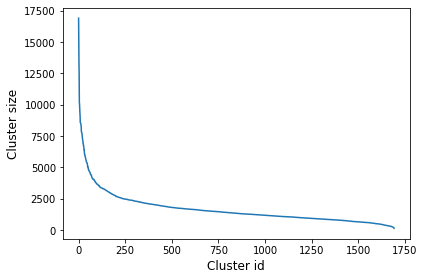

In [106]:
result = plt.plot(range(len(counts)), counts / counts.min())
plt.xlabel("Cluster id", fontsize = 12)
plt.ylabel("Cluster size", fontsize = 12)
plt.tight_layout()

In [107]:
data_in.to_csv("row_data/row_data_in.csv", index = False)

In [108]:
data_out.to_csv("row_data/row_data_out.csv", index = False)

### Split the data into train/test/val splits

In [109]:
data_in.head()

,Time [s],Precursor [ug/m3],Gas [ug/m3] Bin01: lg(C*) = -6.5,Gas [ug/m3] Bin02: lg(C*) = -5.5,Gas [ug/m3] Bin03: lg(C*) = -4.5,Gas [ug/m3] Bin04: lg(C*) = -3.5,Gas [ug/m3] Bin05: lg(C*) = -2.5,Gas [ug/m3] Bin06: lg(C*) = -1.5,Gas [ug/m3] Bin07: lg(C*) = -0.5,Gas [ug/m3] Bin08: lg(C*) = 0.5,...,Aerosol [ug_m3] Bin14: lg(C*) = 6.5,temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id,label,weight
0,1.000000,0.069675,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000e+00,305.065364,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0,400,2.266201
1,301.207794,0.068509,1.899033e-11,1.075089e-10,1.927272e-09,2.182113e-09,1.189935e-07,7.532970e-08,0.000001,0.000007,...,5.512945e-10,304.978044,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0,400,2.266201
2,601.415588,0.067363,1.490621e-10,9.178568e-10,1.226381e-08,8.616596e-09,3.822797e-07,3.184893e-07,0.000004,0.000016,...,5.452908e-10,304.890766,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0,400,2.266201
3,901.623352,0.066235,4.965061e-10,3.173536e-09,3.730373e-08,1.923193e-08,7.917698e-07,7.400927e-07,0.000009,0.000028,...,5.393642e-10,304.803571,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0,21,3.455515
4,1201.831177,0.065126,1.167016e-09,7.627700e-09,8.292921e-08,3.397641e-08,1.350373e-06,1.350192e-06,0.000015,0.000042,...,5.335128e-10,304.716502,52.072802,0.019914,88.598593,1.938279,4.259464,Exp0,21,3.455515


In [132]:
data_out.head()

,Time [s],Precursor [ug/m3],Gas [ug/m3] Bin01: lg(C*) = -6.5,Gas [ug/m3] Bin02: lg(C*) = -5.5,Gas [ug/m3] Bin03: lg(C*) = -4.5,Gas [ug/m3] Bin04: lg(C*) = -3.5,Gas [ug/m3] Bin05: lg(C*) = -2.5,Gas [ug/m3] Bin06: lg(C*) = -1.5,Gas [ug/m3] Bin07: lg(C*) = -0.5,Gas [ug/m3] Bin08: lg(C*) = 0.5,...,Aerosol [ug_m3] Bin09: lg(C*) = 1.5,Aerosol [ug_m3] Bin10: lg(C*) = 2.5,Aerosol [ug_m3] Bin11: lg(C*) = 3.5,Aerosol [ug_m3] Bin12: lg(C*) = 4.5,Aerosol [ug_m3] Bin13: lg(C*) = 5.5,Aerosol [ug_m3] Bin14: lg(C*) = 6.5,id,label,weight,indexer
0,301.207794,0.068509,1.899033e-11,1.075089e-10,1.927272e-09,2.182113e-09,1.189935e-07,7.532970e-08,0.000001,0.000007,...,6.770709e-09,6.041059e-09,1.836918e-09,2.635435e-10,2.962734e-14,5.512945e-10,Exp0,400,3.106473,0
1,601.415588,0.067363,1.490621e-10,9.178568e-10,1.226381e-08,8.616596e-09,3.822797e-07,3.184893e-07,0.000004,0.000016,...,1.573416e-08,1.227994e-08,3.667536e-09,5.291800e-10,1.220129e-13,5.452908e-10,Exp0,400,3.106473,1
2,901.623352,0.066235,4.965061e-10,3.173536e-09,3.730373e-08,1.923193e-08,7.917698e-07,7.400927e-07,0.000009,0.000028,...,2.644237e-08,1.857430e-08,5.461496e-09,7.946631e-10,2.772474e-13,5.393642e-10,Exp0,21,3.463100,2
3,1201.831177,0.065126,1.167016e-09,7.627700e-09,8.292921e-08,3.397641e-08,1.350373e-06,1.350192e-06,0.000015,0.000042,...,3.888504e-08,2.492765e-08,7.219821e-09,1.059928e-09,4.953507e-13,5.335128e-10,Exp0,21,3.463100,3
4,1502.038940,0.064036,2.263815e-09,1.504196e-08,1.546287e-07,5.281122e-08,2.060499e-06,2.158285e-06,0.000022,0.000059,...,5.305184e-08,3.134331e-08,8.943489e-09,1.324905e-09,7.762807e-13,5.277344e-10,Exp0,21,3.463100,4


In [119]:
def stratified_split(df: pd.DataFrame,
                     frac: float,
                     column: List[str]) -> (pd.DataFrame, pd.DataFrame):
    
    label_count = df[column].value_counts().to_dict()
    labels_we_can_use = df[column].apply(lambda x: label_count[x] > 1)
    items_with_count_one = df[~labels_we_can_use].copy()
    items_needing_split = df[labels_we_can_use].copy()
    
    train, test = _train_test_split(
        items_needing_split,
        test_size=frac,
        stratify=items_needing_split[column]
    )
    train = pd.concat([train, items_with_count_one], axis = 0, sort = True)#.reset_index(drop = True)
    return train, test

In [120]:
def train_test_val_split(df: pd.DataFrame,
                         fraction: float = 0.2) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    
    fraction = min(1.0, fraction)
    train, _test = stratified_split(df, fraction, "label") 
    test, val = stratified_split(_test, 0.5, "label") 
    
    return train, test, val

In [138]:
train, test, val = train_test_val_split(data_in, 0.2)

In [139]:
x_train = data_in.iloc[train.index].sort_index()
y_train = data_out.iloc[train.index].sort_index()

In [140]:
x_test = data_in.iloc[test.index].sort_index()
y_test = data_out.iloc[test.index].sort_index()

In [141]:
x_val = data_in.iloc[val.index].sort_index()
y_val = data_out.iloc[val.index].sort_index()

In [149]:
x_train.to_csv("row_data/x_train.csv", index = False, encoding = "utf-8")

In [150]:
x_test.to_csv("row_data/x_test.csv", index = False, encoding = "utf-8")

In [151]:
x_val.to_csv("row_data/x_val.csv", index = False, encoding = "utf-8")

In [152]:
y_train.to_csv("row_data/y_train.csv", index = False, encoding = "utf-8")

In [153]:
y_test.to_csv("row_data/y_test.csv", index = False, encoding = "utf-8")

In [154]:
y_val.to_csv("row_data/y_val.csv", index = False, encoding = "utf-8")

### Create Reader

In [52]:
class LoadGeckoPandas:
    
    def __init__(self, split, data_path, 
                 input_cols, output_cols, 
                 shuffle = True, scaler_x = None, scaler_y = None):
        
        self.data_path = data_path
        self.split = split
        self.input_cols = input_cols
        self.output_cols = output_cols

        self.shuffle = shuffle
        
        self.scaler_x = scaler_x
        self.scaler_y = scaler_y
        
        self.load()
        self.on_epoch_end()
        
    def load(self):
        self.x = pd.read_csv(os.path.join(self.data_path, f"x_{self.split}.csv"))
        self.y = pd.read_csv(os.path.join(self.data_path, f"y_{self.split}.csv"))        
        self.weights = self.y["weight"].copy().to_numpy(dtype=np.float32)
        
        self.x = self.x[self.input_cols].copy()
        self.y = self.y[self.output_cols].copy()
        
        drop_cols = ["index", "id", "indexer"]
        for df in [self.x, self.y]:
            keep_cols = [x for x in df.columns if x not in drop_cols]
            df = df[keep_cols].copy()
            
        if self.scaler_x is not None and self.scaler_y is not None:
            self.x = self.scaler_x.transform(
                self.x.drop(['Time [s]', 'id'], axis=1)
            )
            self.y = self.scaler_y.transform(
                self.y.drop(['Time [s]', 'id'], axis=1)
            )
        else:
            self.scaler_x = Pipeline(
                steps=[('quant', QuantileTransformer()), ('minmax', MinMaxScaler((0, 1)))]
            )
            self.scaler_y = Pipeline(
                steps=[('quant', QuantileTransformer()), ('minmax', MinMaxScaler((0, 1)))]
            )
            self.x = self.scaler_x.fit_transform(
                self.x.drop(['Time [s]', 'id'], axis=1)
            )
            self.y = self.scaler_y.fit_transform(
                self.y.drop(['Time [s]', 'id'], axis=1)
            )
            with open(os.path.join(self.data_path, "scalers.pkl"), "wb") as fid:
                pickle.dump([self.scaler_x, self.scaler_y], fid)
                
    def get_transform(self):
        return self.scaler_x, self.scaler_y
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        
        self.processed += 1
        if self.processed == self.__len__():
            self.on_epoch_end()
        
        x_data = torch.from_numpy(self.x[idx].astype(np.float32))
        y_data = torch.from_numpy(self.y[idx].astype(np.float32))
        w_data = np.array([self.weights[idx].astype(np.float32)])
        w_data = torch.from_numpy(w_data)
        
        return x_data, y_data, w_data
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.processed = 0
        if self.shuffle == True:
            pass

In [63]:
with open("config.yml") as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)

In [54]:
train_reader = LoadGeckoPandas(split = "train", **config["data"])

In [55]:
x, y, w = train_reader.__getitem__(0)

In [70]:
config["iterator"]["batch_size"] = 1024


train_dataloader = DataLoader(
    train_reader,
    **config["iterator"]
)

batches_per_epoch = int(np.ceil(train_reader.__len__() / 1024.0))
batch_group_generator = tqdm(
    train_dataloader,
    total=batches_per_epoch, 
    leave=True
)

  0%|          | 0/2249 [00:00<?, ?it/s]

In [71]:
for stuff in batch_group_generator:
    continue

100%|██████████| 2249/2249 [00:14<00:00, 149.98it/s]


In [66]:
stuff[-1].shape

torch.Size([4, 1])

### And finally we need an experiment generator ...

In [27]:
class LoadGeckoPandasExperiment:
    
    def __init__(self, data_path, input_cols, output_cols):
        
        self.data_path = data_path
        self.input_cols = input_cols
        self.output_cols = output_cols        
        self.load()
    
    def load(self):
        self.x = pd.read_csv(os.path.join(self.data_path, "row_data_in.csv"))
        self.y = pd.read_csv(os.path.join(self.data_path, "row_data_out.csv"))
        
        drop_cols = ["index", "indexer"]
        for df in [self.x, self.y]:
            keep_cols = [x for x in df.columns if x not in drop_cols]
            df = df[keep_cols].copy()
        
        self.x_dict = {
            experiment: group for (experiment, group) in self.x.groupby(["id"])
        }
        self.y_dict = {
            experiment: group for (experiment, group) in self.y.groupby(["id"])
        }
        self.w_dict = {
            experiment: group["weight"] for (experiment, group) in self.y_dict.items()
        }
        
        with open(os.path.join(self.data_path, "scalers.pkl"), "rb") as fid:
            self.scaler_x, self.scaler_y = pickle.load(fid)
               
        self.x_dict = {
            experiment: self.scaler_x.transform(
                group[self.input_cols].drop(['Time [s]', 'id'], axis=1)
            ) 
            for (experiment, group) in self.x_dict.items()
        }
        self.y_dict = {
            experiment: self.scaler_y.transform(
                group[self.output_cols].drop(['Time [s]', 'id'], axis=1)
            ) 
            for (experiment, group) in self.y_dict.items()
        }
        
    def __len__(self):
        return len(self.x_dict)
    
    def __getitem__(self, idx):
        
        X = self.x_dict[f"Exp{idx}"]
        Y = self.y_dict[f"Exp{idx}"]
        W = self.w_dict[f"Exp{idx}"]
        
        for (x, y, w) in zip(X, Y, W):
            x_data = torch.from_numpy(x.astype(np.float32))
            y_data = torch.from_numpy(y.astype(np.float32))
            w_data = torch.from_numpy(np.array([w]))
            yield (x_data, y_data, w_data)

In [28]:
t = LoadGeckoPandasExperiment("row_data", input_vars, output_vars)

In [29]:
for (x, y, w) in t.__getitem__(0):
    print(x.shape, y.shape, w.shape)
    break

torch.Size([35]) torch.Size([29]) torch.Size([1])
